In [4]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import KFold, cross_val_predict, GridSearchCV, train_test_split, cross_val_score

from sklearn.metrics import accuracy_score
from sklearn.metrics import plot_confusion_matrix
from sklearn.metrics import classification_report
import sklearn.metrics as metrics

from sklearn import svm
from sklearn.linear_model import LogisticRegression
from sklearn.discriminant_analysis import LinearDiscriminantAnalysis
from sklearn.ensemble import RandomForestClassifier, GradientBoostingClassifier

import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras import models
from tensorflow.keras import layers
from tensorflow.keras.utils import to_categorical

# 1. Cargar el dataset

In [5]:
base_df = pd.read_csv('/content/heart.csv')
base_df.head(10)

,Age,Sex,ChestPainType,RestingBP,Cholesterol,FastingBS,RestingECG,MaxHR,ExerciseAngina,Oldpeak,ST_Slope,HeartDisease
0,40,M,ATA,140,289,0,Normal,172,N,0.0,Up,0
1,49,F,NAP,160,180,0,Normal,156,N,1.0,Flat,1
2,37,M,ATA,130,283,0,ST,98,N,0.0,Up,0
3,48,F,ASY,138,214,0,Normal,108,Y,1.5,Flat,1
4,54,M,NAP,150,195,0,Normal,122,N,0.0,Up,0
5,39,M,NAP,120,339,0,Normal,170,N,0.0,Up,0
6,45,F,ATA,130,237,0,Normal,170,N,0.0,Up,0
7,54,M,ATA,110,208,0,Normal,142,N,0.0,Up,0
8,37,M,ASY,140,207,0,Normal,130,Y,1.5,Flat,1
9,48,F,ATA,120,284,0,Normal,120,N,0.0,Up,0


# 2. Analisis exploratorio de los datos

In [6]:
base_df.shape

(918, 12)

In [7]:
base_df.dtypes

Age                 int64
Sex                object
ChestPainType      object
RestingBP           int64
Cholesterol         int64
FastingBS           int64
RestingECG         object
MaxHR               int64
ExerciseAngina     object
Oldpeak           float64
ST_Slope           object
HeartDisease        int64
dtype: object

In [8]:
base_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 918 entries, 0 to 917
Data columns (total 12 columns):
 #   Column          Non-Null Count  Dtype  
---  ------          --------------  -----  
 0   Age             918 non-null    int64  
 1   Sex             918 non-null    object 
 2   ChestPainType   918 non-null    object 
 3   RestingBP       918 non-null    int64  
 4   Cholesterol     918 non-null    int64  
 5   FastingBS       918 non-null    int64  
 6   RestingECG      918 non-null    object 
 7   MaxHR           918 non-null    int64  
 8   ExerciseAngina  918 non-null    object 
 9   Oldpeak         918 non-null    float64
 10  ST_Slope        918 non-null    object 
 11  HeartDisease    918 non-null    int64  
dtypes: float64(1), int64(6), object(5)
memory usage: 86.2+ KB


El dataset se compone de las siguiente 12 variables: 
* Age: age of the patient [years]
* Sex: sex of the patient [M: Male, F: Female]
* ChestPainType: chest pain type [TA: Typical Angina, ATA: * Atypical Angina, NAP: Non-Anginal Pain, ASY: Asymptomatic]
* RestingBP: resting blood pressure [mm Hg]
* Cholesterol: serum cholesterol [mm/dl]
* FastingBS: fasting blood sugar [1: if FastingBS > 120 mg/dl, 0: otherwise]
* RestingECG: resting electrocardiogram results [Normal: Normal, ST: having ST-T wave abnormality (T wave inversions and/or ST elevation or depression of > 0.05 mV), LVH: showing probable or definite left ventricular hypertrophy by Estes' criteria]
* MaxHR: maximum heart rate achieved [Numeric value between 60 and 202]
* ExerciseAngina: exercise-induced angina [Y: Yes, N: No]
Oldpeak: oldpeak = ST [Numeric value measured in depression]
ST_Slope: the slope of the peak exercise ST segment [Up: upsloping, Flat: flat, Down: downsloping]
* HeartDisease: output class [1: heart disease, 0: Normal]

Distinguir variables categoricas de las númericas

In [9]:
cat_columns = ['Sex', 'ChestPainType', 'RestingECG',
               'ExerciseAngina', 'ST_Slope']

num_columns = list(set(base_df.columns) - set(cat_columns))

print('Variables númericas:')
print(num_columns)
print('\n')
print('Variables categoricas:')
print(cat_columns)

Variables númericas:
['FastingBS', 'RestingBP', 'HeartDisease', 'Cholesterol', 'Age', 'MaxHR', 'Oldpeak']


Variables categoricas:
['Sex', 'ChestPainType', 'RestingECG', 'ExerciseAngina', 'ST_Slope']


## 2.1 Datos estadísticos de las variables númericas

In [10]:
print('Datos estadíticos de las variables númericas:')
for column in num_columns:
    cuartiles = base_df[column].quantile([.25, .50, .75])

    print('Variable ' + column + ':')
    print('MAX:', base_df[column].max())
    print('MIN:', base_df[column].min())
    print('MEDIA:', base_df[column].mean())
    print('MEDIANA:', base_df[column].median())
    print('25%:', cuartiles.iloc[0])
    print('50%:', cuartiles.iloc[1])
    print('75%:', cuartiles.iloc[2])
    print('\n')

Datos estadíticos de las variables númericas:
Variable FastingBS:
MAX: 1
MIN: 0
MEDIA: 0.23311546840958605
MEDIANA: 0.0
25%: 0.0
50%: 0.0
75%: 0.0


Variable RestingBP:
MAX: 200
MIN: 0
MEDIA: 132.39651416122004
MEDIANA: 130.0
25%: 120.0
50%: 130.0
75%: 140.0


Variable HeartDisease:
MAX: 1
MIN: 0
MEDIA: 0.5533769063180828
MEDIANA: 1.0
25%: 0.0
50%: 1.0
75%: 1.0


Variable Cholesterol:
MAX: 603
MIN: 0
MEDIA: 198.7995642701525
MEDIANA: 223.0
25%: 173.25
50%: 223.0
75%: 267.0


Variable Age:
MAX: 77
MIN: 28
MEDIA: 53.510893246187365
MEDIANA: 54.0
25%: 47.0
50%: 54.0
75%: 60.0


Variable MaxHR:
MAX: 202
MIN: 60
MEDIA: 136.80936819172112
MEDIANA: 138.0
25%: 120.0
50%: 138.0
75%: 156.0


Variable Oldpeak:
MAX: 6.2
MIN: -2.6
MEDIA: 0.8873638344226581
MEDIANA: 0.6
25%: 0.0
50%: 0.6
75%: 1.5




Distribución de las variables númericas

/usr/local/lib/python3.7/dist-packages/seaborn/distributions.py:2619: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)
/usr/local/lib/python3.7/dist-packages/seaborn/distributions.py:2619: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)
/usr/local/lib/python3.7/dist-packages/seaborn/distributions.py:2619: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function 

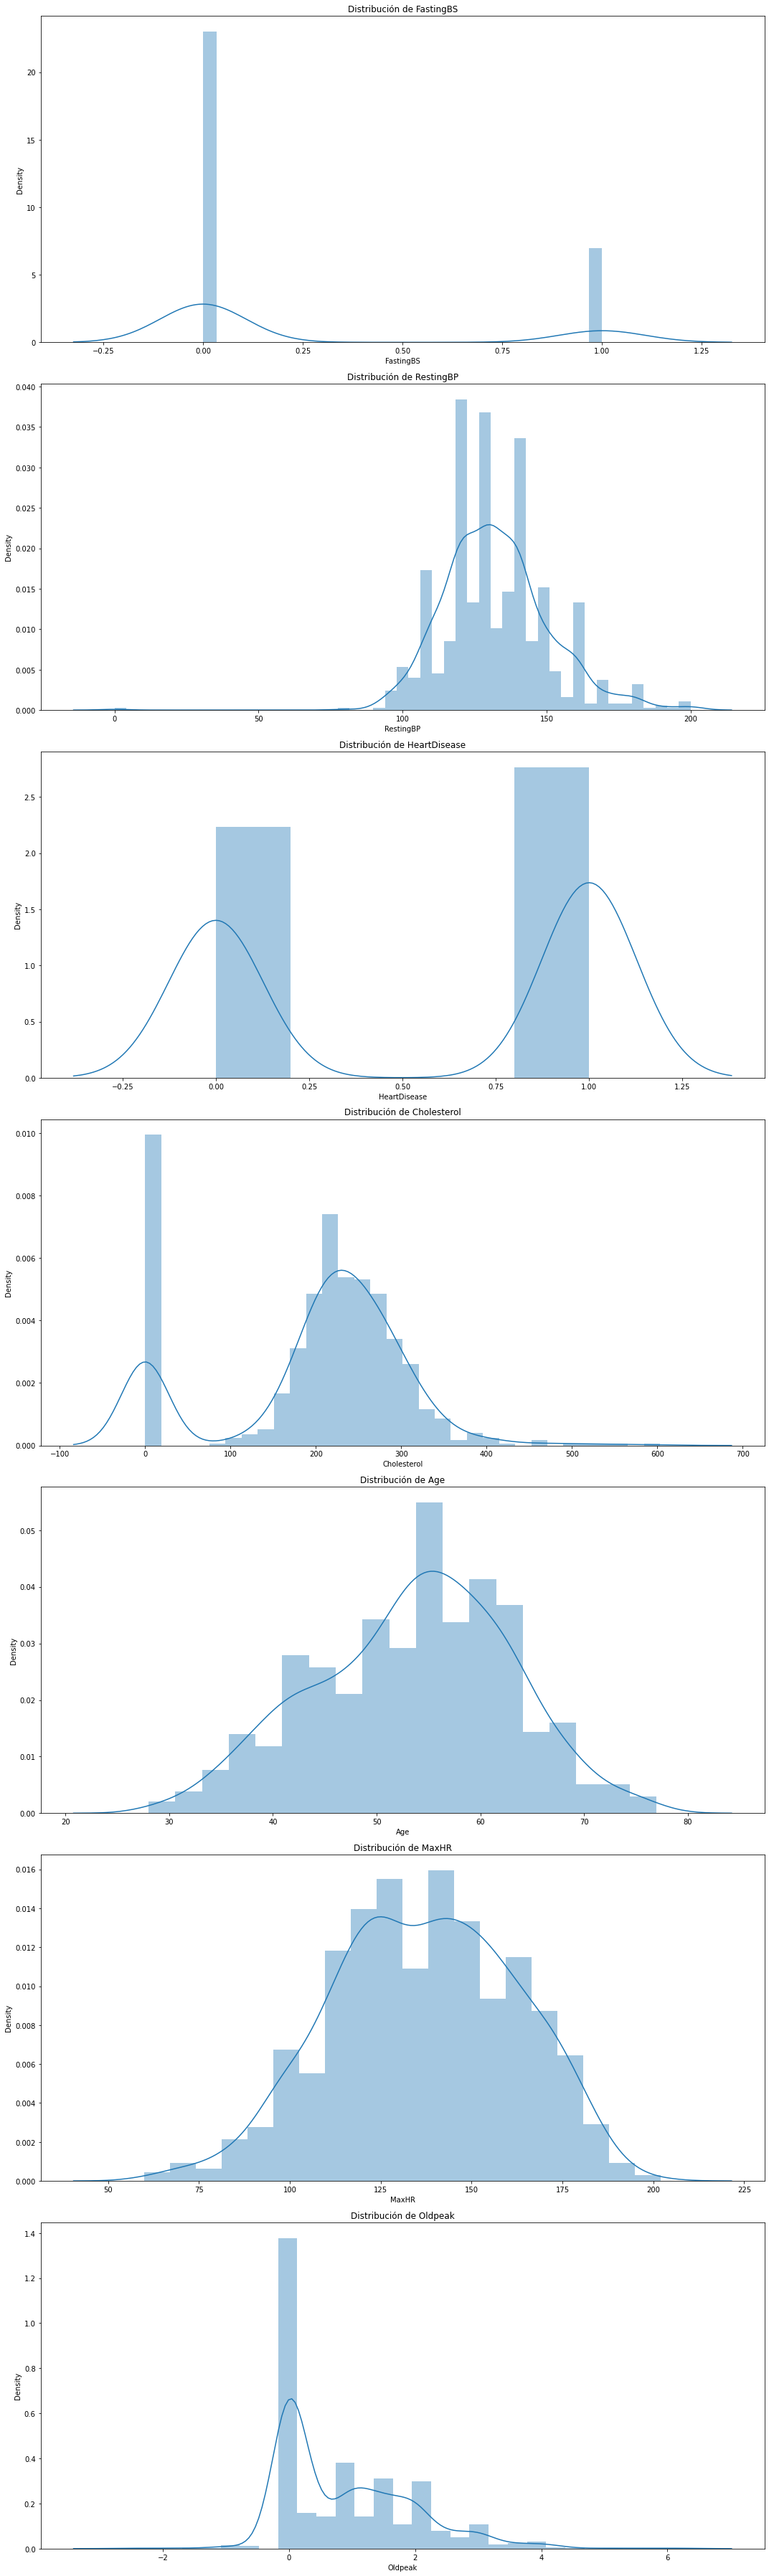

In [11]:
fig, axs = plt.subplots(len(num_columns), 1, figsize=(15, 50))

count = 0
for column in num_columns:
    fp = sns.distplot(base_df[column], ax=axs[count])
    fp.set_title(f'Distribución de {column}')
    count += 1

plt.tight_layout();

## 2.2 Frecuencia de las variables categoricas

In [12]:
for column in cat_columns:
    print(f'Variable {column}:')
    print(f'Listado categorias: \n{base_df[column].unique()}')
    print(f'Frecuencia categorias: \n{base_df[column].value_counts()}')
    print('\n')

Variable Sex:
Listado categorias: 
['M' 'F']
Frecuencia categorias: 
M    725
F    193
Name: Sex, dtype: int64


Variable ChestPainType:
Listado categorias: 
['ATA' 'NAP' 'ASY' 'TA']
Frecuencia categorias: 
ASY    496
NAP    203
ATA    173
TA      46
Name: ChestPainType, dtype: int64


Variable RestingECG:
Listado categorias: 
['Normal' 'ST' 'LVH']
Frecuencia categorias: 
Normal    552
LVH       188
ST        178
Name: RestingECG, dtype: int64


Variable ExerciseAngina:
Listado categorias: 
['N' 'Y']
Frecuencia categorias: 
N    547
Y    371
Name: ExerciseAngina, dtype: int64


Variable ST_Slope:
Listado categorias: 
['Up' 'Flat' 'Down']
Frecuencia categorias: 
Flat    460
Up      395
Down     63
Name: ST_Slope, dtype: int64




Distribucióon de las variables categoricas

/usr/local/lib/python3.7/dist-packages/seaborn/_decorators.py:43: FutureWarning: Pass the following variable as a keyword arg: x. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  FutureWarning
/usr/local/lib/python3.7/dist-packages/seaborn/_decorators.py:43: FutureWarning: Pass the following variable as a keyword arg: x. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  FutureWarning
/usr/local/lib/python3.7/dist-packages/seaborn/_decorators.py:43: FutureWarning: Pass the following variable as a keyword arg: x. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  FutureWarning
/usr/local/lib/python3.7/dist-packages/seaborn

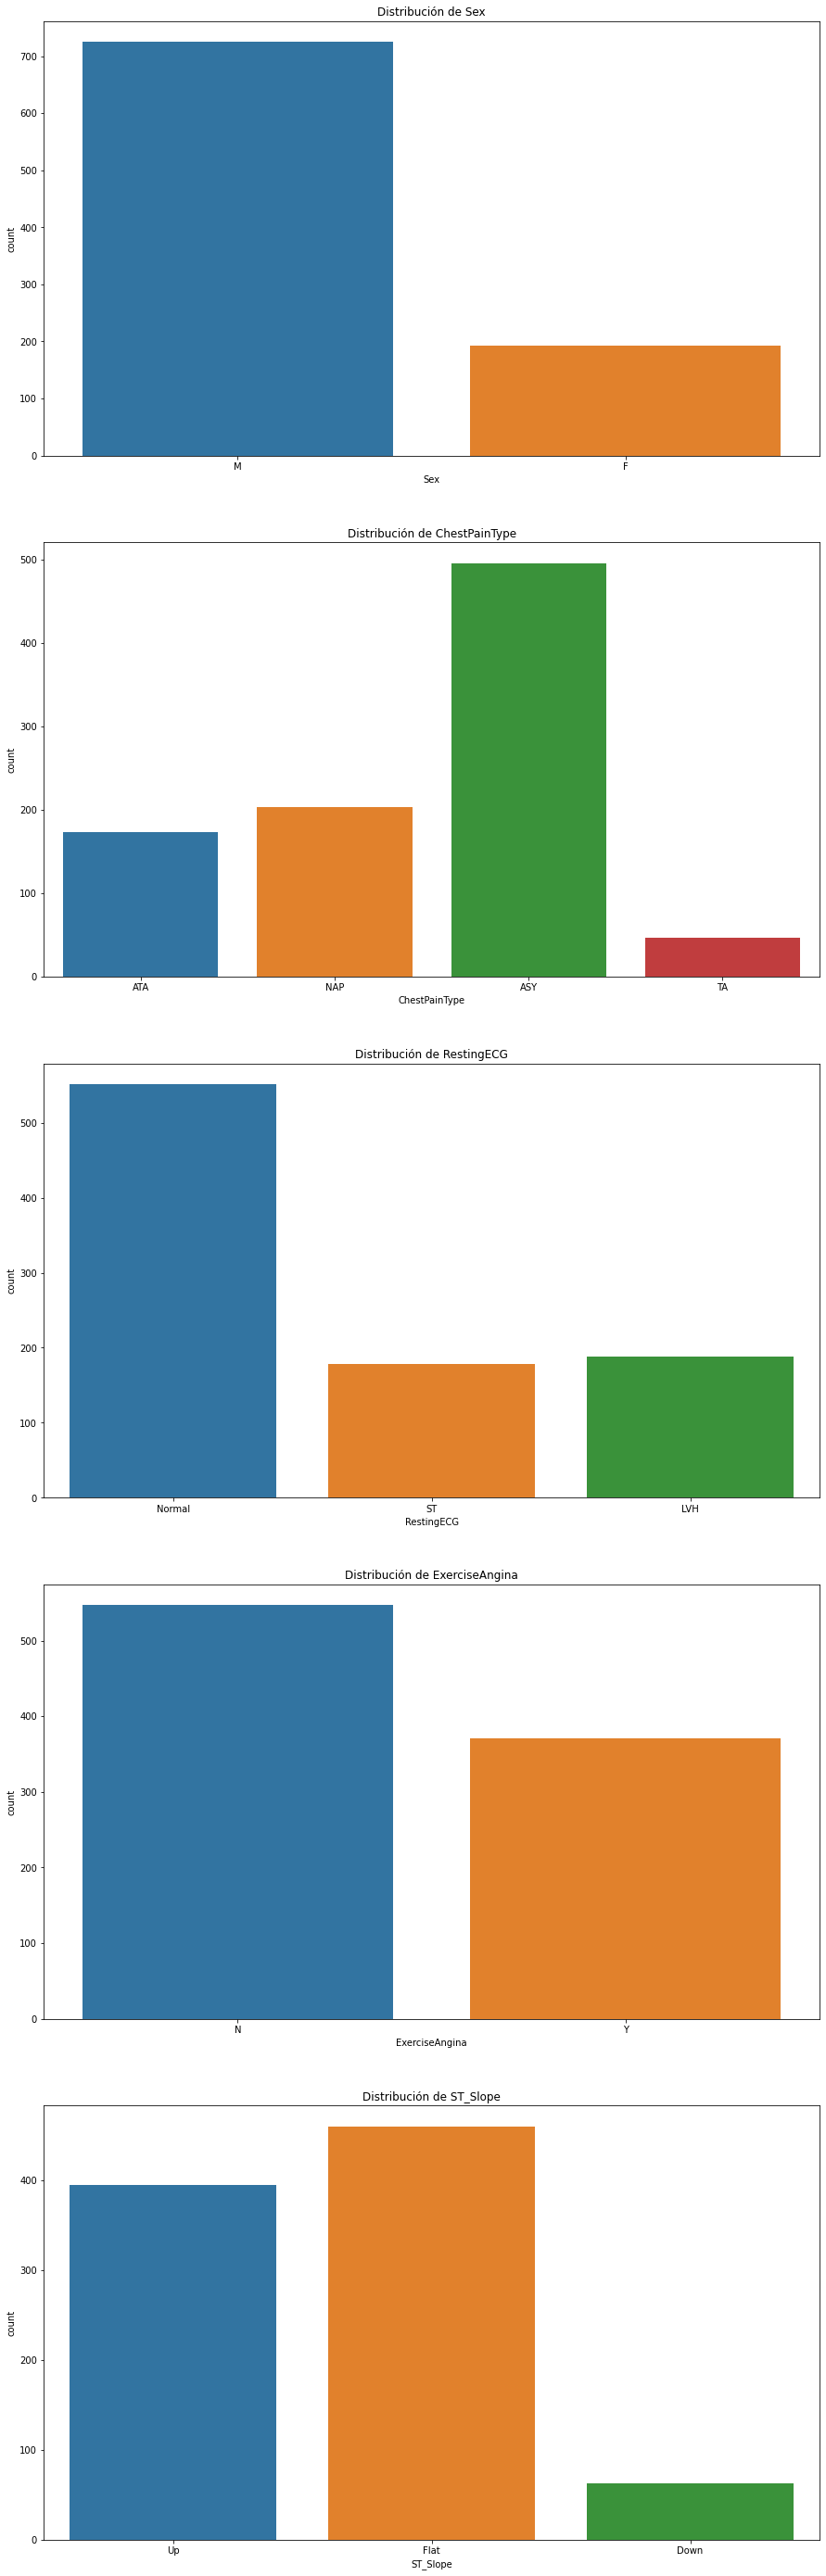

In [13]:
fig, axs = plt.subplots(len(cat_columns), 1, figsize=(15, 50))

count = 0
for column in cat_columns:
    fp = sns.countplot(base_df[column], ax=axs[count])
    fp.set_title(f'Distribución de {column}')
    fp.set_xticklabels(base_df[column].unique())
    count += 1

## 2.3 Matriz de correlación

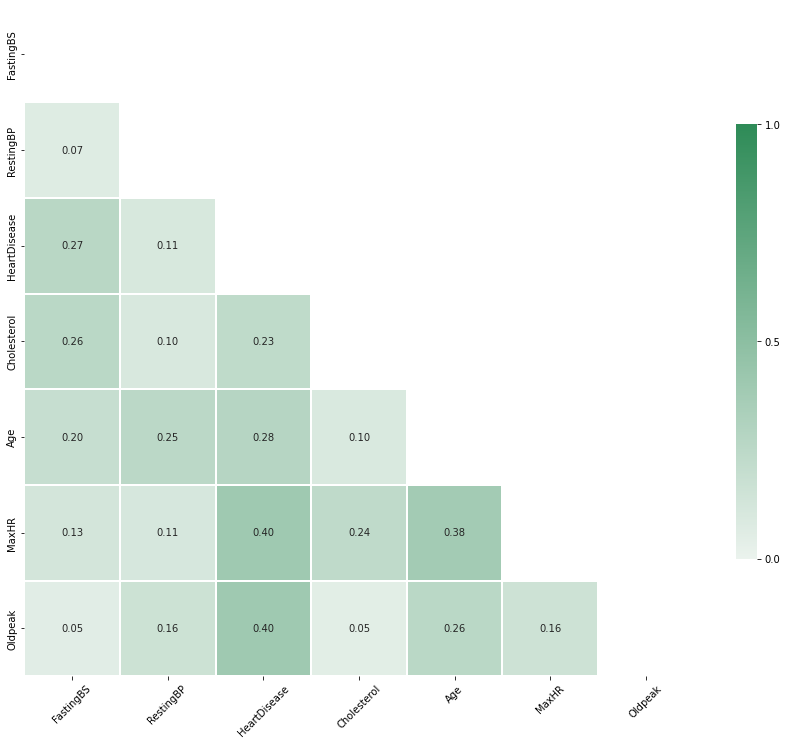

In [14]:
# Calcular correlacion de las variables numericas.
df_matrix_corr = base_df[num_columns].corr(method='pearson').abs()

# Triangulo inferior de la matrix de correlacion
mask = np.triu(np.ones(df_matrix_corr.shape)).astype(np.bool)

# Grafico de la matriz de correlacion
f, ax = plt.subplots(figsize=(15, 20))
ax.set_yticklabels(df_matrix_corr.columns[1:], rotation=0)
ax.set_xticklabels(df_matrix_corr.columns[:-1], rotation=45)
heatmap = sns.heatmap(
    df_matrix_corr,
    mask=mask,
    square=True,
    linewidths=1,
    cmap=sns.light_palette('seagreen', as_cmap=True),
    cbar_kws={'shrink': .4, 'ticks': [-1, -.5, 0, 0.5, 1]},
    vmin=0,
    vmax=1,
    annot=True,
    annot_kws={"size": 10},
    fmt=".2f"
)

In [15]:
umbral = 0.75
corr_stack = df_matrix_corr.where(mask).stack().reset_index()
corr_stack.columns = ['Row', 'Column', 'Correlation Value']
corr_75 = corr_stack[(corr_stack['Correlation Value'] > umbral) &
                     (corr_stack['Correlation Value'] < 1)]
corr_75 = corr_75.sort_values(
    by='Correlation Value',
    kind="quicksort",
    ascending=False).drop_duplicates(keep='first')
print(corr_75)

Empty DataFrame
Columns: [Row, Column, Correlation Value]
Index: []


No existe una correlación elevada entre diferente variables (superior a 75%), por tanto, se ha considerado no eliminar nigúna variable.

Se oberva una gran correlación positiva a las siguientes variables:
* *Oldpeak* -> *HeartDisease*
* *Ages* -> *HeartDisease*

Por tanto, *Oldpeak* y *ages*, tiene gran importancia, ya que parece ser estas variables tienen una relación directa con la variable a predecir *HeartDisease*.

# 3. Limpieza de *datos*

Antes de realizar cualquier evaluación sobre los datos es importante siempre realizar un tratamiento previo a fin de abordar que hacer con la información faltante. Se citan algunos ejemplos:

* Si la cantidad de datos faltantes es muy grande se recomienda borrar estas variables.
Si existe una cantidad pequeña de filas con datos faltantes en sus variables se puede optar por borrarlas.
* Para variables categóricas se puede agregar un estado adicional que describa este factor.
Se puede llenar los datos faltantes con la media, mediana o moda de esa variable tanto para variables numéricas o categóricas.
* Para variables categóricas, se puede optar por una asignación aleatoria de categorías escogido aquellas que se encuentren presentes en esa variable, tratado de buscar que se encuentren uniformemente distribuidas.

En este caso, no existen datos faltantes en ninguna variable del dataset

In [16]:
percent_null = (base_df.isnull().sum() / len(base_df)) * 100
print(percent_null)

Age               0.0
Sex               0.0
ChestPainType     0.0
RestingBP         0.0
Cholesterol       0.0
FastingBS         0.0
RestingECG        0.0
MaxHR             0.0
ExerciseAngina    0.0
Oldpeak           0.0
ST_Slope          0.0
HeartDisease      0.0
dtype: float64


# 4. Modelado

## 4.1 SVM

Se separá la variable objetivo de las demás variables.

In [17]:
x = base_df.drop(columns='HeartDisease')
y = base_df['HeartDisease']

In [18]:
x.head(10)

,Age,Sex,ChestPainType,RestingBP,Cholesterol,FastingBS,RestingECG,MaxHR,ExerciseAngina,Oldpeak,ST_Slope
0,40,M,ATA,140,289,0,Normal,172,N,0.0,Up
1,49,F,NAP,160,180,0,Normal,156,N,1.0,Flat
2,37,M,ATA,130,283,0,ST,98,N,0.0,Up
3,48,F,ASY,138,214,0,Normal,108,Y,1.5,Flat
4,54,M,NAP,150,195,0,Normal,122,N,0.0,Up
5,39,M,NAP,120,339,0,Normal,170,N,0.0,Up
6,45,F,ATA,130,237,0,Normal,170,N,0.0,Up
7,54,M,ATA,110,208,0,Normal,142,N,0.0,Up
8,37,M,ASY,140,207,0,Normal,130,Y,1.5,Flat
9,48,F,ATA,120,284,0,Normal,120,N,0.0,Up


In [19]:
y.head(10)

0    0
1    1
2    0
3    1
4    0
5    0
6    0
7    0
8    1
9    0
Name: HeartDisease, dtype: int64

Separación Hold out. Se utiliza 10% del dataset para test y 90% para entrenamiento y validación, ya que solo se dispone de un dataset con menos de 1000 muestras. Se normalizán los datos y se utiliza one hot enconding en la variables categoricas.

In [21]:
x_train, x_test, y_train, y_test = train_test_split(x,
                                                    y,
                                                    test_size=0.1,
                                                    random_state=1234)

# Normalización: Media y desviación.
sc = StandardScaler()
x_train = sc.fit_transform(pd.get_dummies(x_train))

x_test = sc.fit_transform(pd.get_dummies(x_test))

In [22]:
parameters = [{'kernel': ['rbf'], 'gamma': [1e-3, 1e-4],
                     'C': [1, 10, 100, 1000]},
                    {'kernel': ['linear'], 'C': [1, 10, 100, 1000]}]

clf = GridSearchCV(svm.SVC(), parameters, scoring='accuracy', cv=10)
clf.fit(x_train, y_train)

print("Best parameters set found on development set:")
print()
print(clf.best_params_)

Best parameters set found on development set:

{'C': 100, 'gamma': 0.001, 'kernel': 'rbf'}


In [24]:
svm_model = svm.SVC(kernel=clf.best_params_['kernel'], C=clf.best_params_['C'], random_state=42)
svm_model = svm_model.fit(x_train, y_train)
predicted = svm_model.predict(x_test)

In [25]:
def counts_from_confusion(confusion_matrix):
    count = []

    # Iterate through classes and store the counts
    for i in range(confusion_matrix.shape[0]):
        tp = confusion_matrix[i, i]

        fn_mask = np.zeros(confusion_matrix.shape)
        fn_mask[i, :] = 1
        fn_mask[i, i] = 0
        fn = np.sum(np.multiply(confusion_matrix, fn_mask))

        fp_mask = np.zeros(confusion_matrix.shape)
        fp_mask[:, i] = 1
        fp_mask[i, i] = 0
        fp = np.sum(np.multiply(confusion_matrix, fp_mask))

        tn_mask = 1 - (fn_mask + fp_mask)
        tn_mask[i, i] = 0
        tn = np.sum(np.multiply(confusion_matrix, tn_mask))

        count.append({'Clase': i,
                      'TP': tp,
                      'FN': fn,
                      'FP': fp,
                      'TN': tn})

    tp = (count[0]['TP'] + count[1]['TP'])
    tn = (count[0]['TN'] + count[1]['TN'])
    fp = (count[0]['FP'] + count[1]['FP'])
    fn = (count[0]['FN'] + count[1]['FN'])

    return tp, tn, fp, fn, count

[[30  9]
 [ 9 44]]
Métricas evaluación:
Accuracy: 0.80
Recall: 0.80
F1: 0.80
Specificity: 0.80
Sensibility: 0.80


/usr/local/lib/python3.7/dist-packages/sklearn/utils/deprecation.py:87: FutureWarning: Function plot_confusion_matrix is deprecated; Function `plot_confusion_matrix` is deprecated in 1.0 and will be removed in 1.2. Use one of the class methods: ConfusionMatrixDisplay.from_predictions or ConfusionMatrixDisplay.from_estimator.
  warnings.warn(msg, category=FutureWarning)


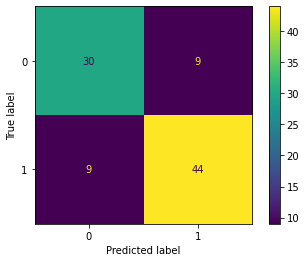

[{'Clase': 0, 'TP': 30, 'FN': 9.0, 'FP': 9.0, 'TN': 44.0}, {'Clase': 1, 'TP': 44, 'FN': 9.0, 'FP': 9.0, 'TN': 30.0}]


In [26]:
confusion_matrix = metrics.confusion_matrix(y_test, predicted)
print(confusion_matrix)
tp, tn, fp, fn, dict_confusion = counts_from_confusion(confusion_matrix)

accuracy = metrics.accuracy_score(y_test, predicted)
recall = metrics.recall_score(y_test, predicted, average='micro')
f1 = metrics.f1_score(y_test, predicted, average='micro')
specificity = tn/(tn + fp)
sensibility = tp/(tp + fn)


print("Métricas evaluación:")
print(f"Accuracy: {accuracy:.2f}")
print(f"Recall: {recall:.2f}")
print(f"F1: {f1:.2f}")
print(f"Specificity: {specificity:.2f}")
print(f"Sensibility: {sensibility:.2f}")

# Visualizar matriz de confusión
metrics.plot_confusion_matrix(svm_model, x_test, y_test)
plt.show()
print(dict_confusion)

## 4.2 Red neuronal

In [27]:
data = pd.read_csv('/content/heart.csv')
x = pd.get_dummies(data.drop(columns='HeartDisease'))
y = data['HeartDisease'].to_numpy()

# Normalización: Media y desviación.
sc = StandardScaler()
x = sc.fit_transform(x)

y = to_categorical(y)
print(x)
print(y)

x_train, x_test, y_train, y_test = train_test_split(x,
                                                    y,
                                                    test_size=0.1,
                                                    random_state=1234)

print(f"Datos entrenamiento y validacion: {x_train.shape} {y_train.shape}")
print(f"Datos test: {x_test.shape} {y_test.shape}")

[[-1.4331398   0.41090889  0.82507026 ... -0.27144836 -1.00218103
   1.15067399]
 [-0.47848359  1.49175234 -0.17196105 ... -0.27144836  0.99782372
  -0.86905588]
 [-1.75135854 -0.12951283  0.7701878  ... -0.27144836 -1.00218103
   1.15067399]
 ...
 [ 0.37009972 -0.12951283 -0.62016778 ... -0.27144836  0.99782372
  -0.86905588]
 [ 0.37009972 -0.12951283  0.34027522 ... -0.27144836  0.99782372
  -0.86905588]
 [-1.64528563  0.30282455 -0.21769643 ... -0.27144836 -1.00218103
   1.15067399]]
[[1. 0.]
 [0. 1.]
 [1. 0.]
 ...
 [0. 1.]
 [0. 1.]
 [1. 0.]]
Datos entrenamiento y validacion: (826, 20) (826, 2)
Datos test: (92, 20) (92, 2)


Se utiliza cross validation en la fase entrenamiento con 10 folds. Se utiliza una red neuronal de 4 capas(incluyendo la de entrada). Las 2 capas escondidas son de 16 y 8 neuronas, todas interconectas. Como una función de activación ReLU, que es un estandard. Como capa de salida, se ha utilizado 2 neuronas, una por clase a predecir. Como función de activación, se ha elegido softmax, ya que se trata de un problema de clasificación multiclase. También se ha utilizado la técnica de dropout para evitar que el modelo sobre entrene y intentar que generealize mejor, desconectando de forma aleatoria las conexiones entre neuronas.

Como algoritmo de optimización se ha utilizado rmsprop: Es una modificación del algoritmo Adagrad. Decrementa la tasa de aprendizaje de forma monótona. Además, en vez de acumular todos los gradientes al cuadrado pasados, restringe el número acumulado con un tamaño fijo $w$ y realiza un promedio exponencial de todos los gradientes cuadrados pasados $E[g^{2}]_{t}$. Al no tener que acumular todos los gradientes se hace mucho más eficiente. Incorpora $\gamma$ como la fracción igual que se hace en el algoritmo de momentum. Los autores recomiendan utilizar valores de $\gamma=$ 0.9 y $\eta = $ 0.001.

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 dense (Dense)               (None, 16)                336       
                                                                 
 dropout (Dropout)           (None, 16)                0         
                                                                 
 dense_1 (Dense)             (None, 8)                 136       
                                                                 
 dropout_1 (Dropout)         (None, 8)                 0         
                                                                 
 dense_2 (Dense)             (None, 2)                 18        
                                                                 
Total params: 490
Trainable params: 490
Non-trainable params: 0
_________________________________________________________________
----------------------------------------------------------

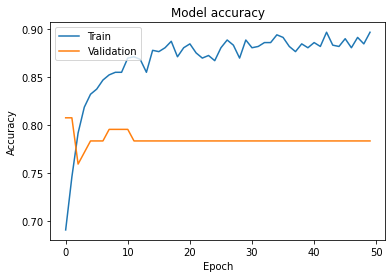

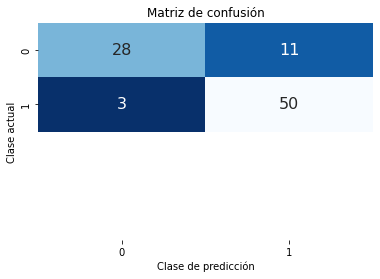

----------------------------------------------------------------
Entrenando para el Fold 1
loss of 0.32528311014175415
accuracy of 88.04348111152649%


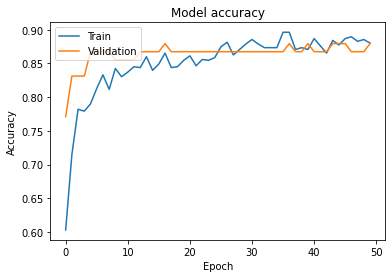

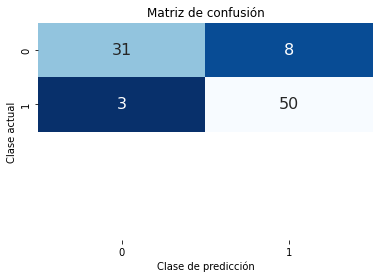

----------------------------------------------------------------
Entrenando para el Fold 2
loss of 0.32821962237358093
accuracy of 84.78260636329651%


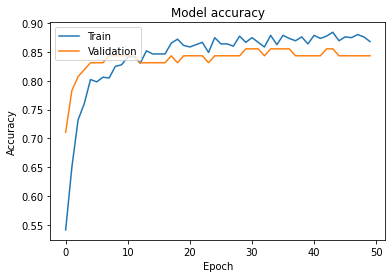

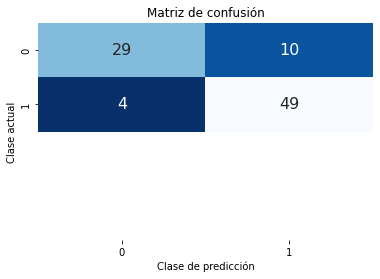

----------------------------------------------------------------
Entrenando para el Fold 3
loss of 0.3526230752468109
accuracy of 85.86956262588501%


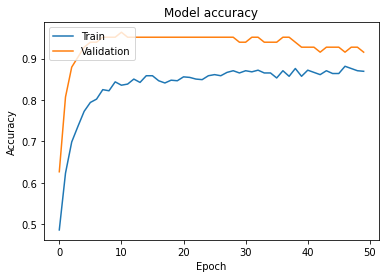

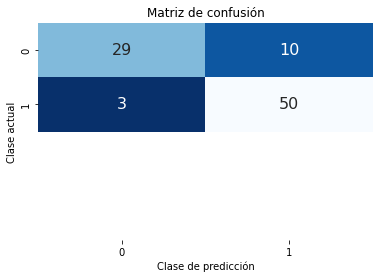

----------------------------------------------------------------
Entrenando para el Fold 4
loss of 0.32467859983444214
accuracy of 86.95651888847351%


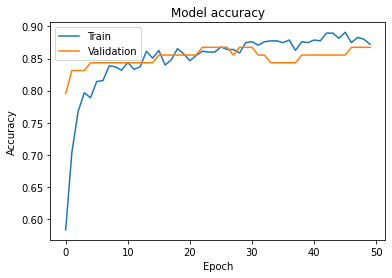

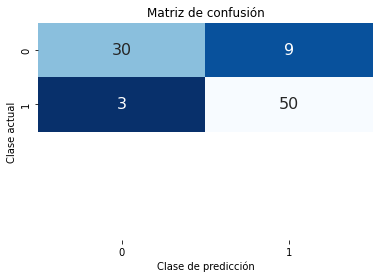

----------------------------------------------------------------
Entrenando para el Fold 5
loss of 0.35050368309020996
accuracy of 83.69565010070801%


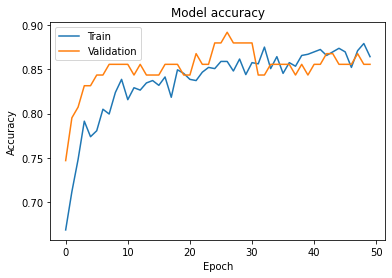

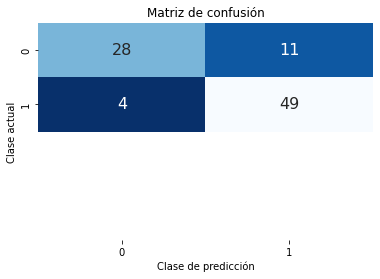

----------------------------------------------------------------
Entrenando para el Fold 6
loss of 0.3421115577220917
accuracy of 86.95651888847351%


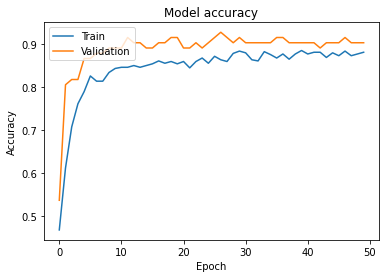

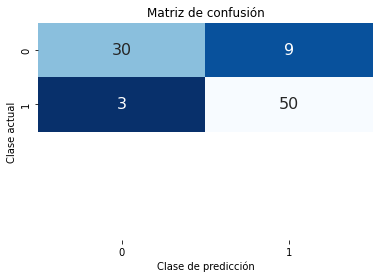

----------------------------------------------------------------
Entrenando para el Fold 7
loss of 0.3696430027484894
accuracy of 84.78260636329651%


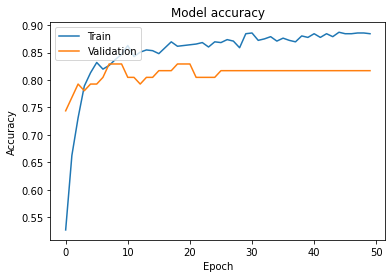

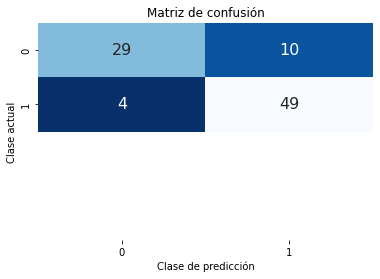

----------------------------------------------------------------
Entrenando para el Fold 8
loss of 0.41920343041419983
accuracy of 81.521737575531%


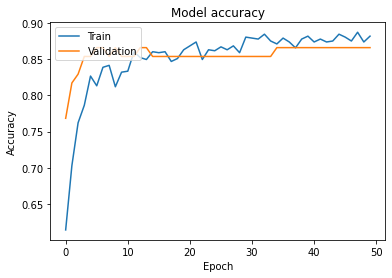

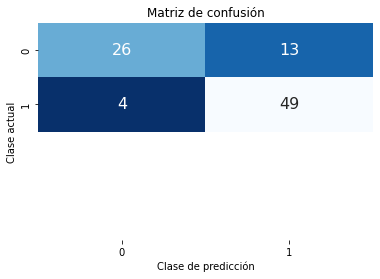

----------------------------------------------------------------
Entrenando para el Fold 9
loss of 0.36364859342575073
accuracy of 84.78260636329651%


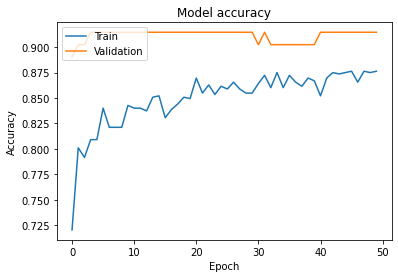

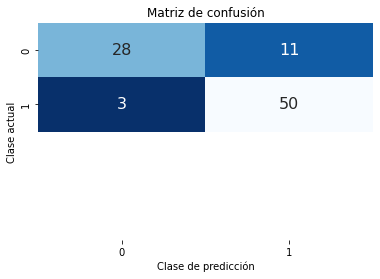


La accuracy media es de 85.21738946437836
La loss media es de 0.3515920042991638


In [28]:
kfold = KFold(n_splits=10, shuffle=True)

fold = 0
accuracy_fold = []
loss_fold = []
for train, validate in kfold.split(x_train, y_train):
    # Datos entrenamiento
    x_train_fold = x_train[train]
    y_train_fold = y_train[train]

    # Datos validacion
    x_valdiate_fold = x_train[validate]
    y_valdiate_fold = y_train[validate]

    # Model
    model = models.Sequential()
    model.add(layers.Dense(16, activation='relu'))
    model.add(layers.Dropout(0.25))
    model.add(layers.Dense(8, activation='relu'))
    model.add(layers.Dropout(0.25))
    model.add(layers.Dense(2, activation='softmax'))

    model.compile(optimizer='rmsprop',
                loss='categorical_crossentropy',
                metrics=['accuracy'])
    
    # Entrenamiento
    history = model.fit(x_train_fold, y_train_fold,
              validation_data=(x_valdiate_fold, y_valdiate_fold),
              batch_size=16,
              epochs=50,
              verbose=0)

    # Test
    prediction_fold = model.evaluate(x_test, y_test, verbose=0)
    y_predicted = model.predict(x_test)

    if fold == 0:
        model.summary()

    print("----------------------------------------------------------------")
    print(f"Entrenando para el Fold {fold}")
    print(f"{model.metrics_names[0]} of {prediction_fold[0]}")
    print(f"{model.metrics_names[1]} of {prediction_fold[1]*100}%")

    plt.plot(history.history['accuracy'])
    plt.plot(history.history['val_accuracy'])
    plt.title('Model accuracy')
    plt.ylabel('Accuracy')
    plt.xlabel('Epoch')
    plt.legend(['Train', 'Validation'], loc='upper left')
    plt.show()

    mc = metrics.confusion_matrix(y_test.argmax(axis=1), 
                                  y_predicted.argmax(axis=1))    
    fig, ax = plt.subplots()
    ax = sns.heatmap(
        mc,
        fmt='.4g',
        annot = True,
        annot_kws={'size': 16},
        cmap= 'Blues_r',
        cbar = False)

    plt.title('Matriz de confusión')
    plt.ylabel('Clase actual')
    plt.xlabel('Clase de predicción')
    plt.ylim(4, 0)
    plt.show()

    accuracy_fold.append(prediction_fold[1] * 100)
    loss_fold.append(prediction_fold[0])

    fold += 1

acc_mean = np.array(accuracy_fold).mean()
loss_mean = np.array(loss_fold).mean()
print(f"\nLa accuracy media es de {acc_mean}")
print(f"La loss media es de {loss_mean}")

## 4.3 Regresión logística

In [29]:
data = pd.read_csv('/content/heart.csv')
x = pd.get_dummies(data.drop(columns='HeartDisease'))
y = data['HeartDisease']

x_train, x_test, y_train, y_test = train_test_split(x,
                                                    y,
                                                    test_size=0.2,
                                                    random_state=1234)

print(f"Datos entrenamiento y validacion: {x_train.shape} {y_train.shape}")
print(f"Datos test: {x_test.shape} {y_test.shape}")

Datos entrenamiento y validacion: (734, 20) (734,)
Datos test: (184, 20) (184,)


In [30]:
logistic_regression = LogisticRegression(max_iter=20000, penalty='l2')
model = logistic_regression.fit(x_train, y_train)
predicted = logistic_regression.predict(x_test)

Métricas evaluación:
Accuracy: 0.88
Recall: 0.88
F1: 0.88
Specificity: 0.88
Sensibility: 0.88


/usr/local/lib/python3.7/dist-packages/sklearn/utils/deprecation.py:87: FutureWarning: Function plot_confusion_matrix is deprecated; Function `plot_confusion_matrix` is deprecated in 1.0 and will be removed in 1.2. Use one of the class methods: ConfusionMatrixDisplay.from_predictions or ConfusionMatrixDisplay.from_estimator.
  warnings.warn(msg, category=FutureWarning)


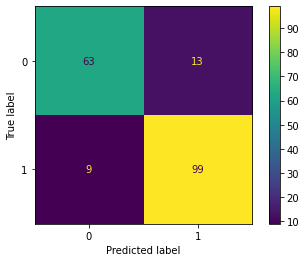

[{'Clase': 0, 'TP': 63, 'FN': 13.0, 'FP': 9.0, 'TN': 99.0}, {'Clase': 1, 'TP': 99, 'FN': 9.0, 'FP': 13.0, 'TN': 63.0}]


In [31]:
confusion_matrix = metrics.confusion_matrix(y_test, predicted)
tp, tn, fp, fn, dict_confusion = counts_from_confusion(confusion_matrix)

accuracy = metrics.accuracy_score(y_test, predicted)
recall = metrics.recall_score(y_test, predicted, average='micro')
f1 = metrics.f1_score(y_test, predicted, average='micro')
specificity = tn/(tn + fp)
sensibility = tp/(tp + fn)


print("Métricas evaluación:")
print(f"Accuracy: {accuracy:.2f}")
print(f"Recall: {recall:.2f}")
print(f"F1: {f1:.2f}")
print(f"Specificity: {specificity:.2f}")
print(f"Sensibility: {sensibility:.2f}")

# Visualizar matriz de confusión
metrics.plot_confusion_matrix(model, x_test, y_test)
plt.show()
print(dict_confusion)

## 4.4 Analisis discriminante lineal

In [32]:
lda = LinearDiscriminantAnalysis()
model = lda.fit(x_train, y_train)
predicted = lda.predict(x_test)

Métricas evaluación:
Accuracy: 0.88
Recall: 0.88
F1: 0.88
Specificity: 0.88
Sensibility: 0.88


/usr/local/lib/python3.7/dist-packages/sklearn/utils/deprecation.py:87: FutureWarning: Function plot_confusion_matrix is deprecated; Function `plot_confusion_matrix` is deprecated in 1.0 and will be removed in 1.2. Use one of the class methods: ConfusionMatrixDisplay.from_predictions or ConfusionMatrixDisplay.from_estimator.
  warnings.warn(msg, category=FutureWarning)


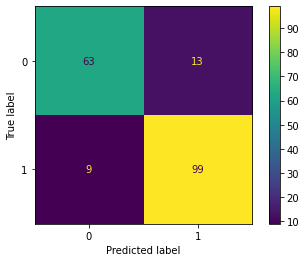

[{'Clase': 0, 'TP': 63, 'FN': 13.0, 'FP': 9.0, 'TN': 99.0}, {'Clase': 1, 'TP': 99, 'FN': 9.0, 'FP': 13.0, 'TN': 63.0}]


In [33]:
confusion_matrix = metrics.confusion_matrix(y_test, predicted)
tp, tn, fp, fn, dict_confusion = counts_from_confusion(confusion_matrix)

accuracy = metrics.accuracy_score(y_test, predicted)
recall = metrics.recall_score(y_test, predicted, average='micro')
f1 = metrics.f1_score(y_test, predicted, average='micro')
specificity = tn/(tn + fp)
sensibility = tp/(tp + fn)


print("Métricas evaluación:")
print(f"Accuracy: {accuracy:.2f}")
print(f"Recall: {recall:.2f}")
print(f"F1: {f1:.2f}")
print(f"Specificity: {specificity:.2f}")
print(f"Sensibility: {sensibility:.2f}")

# Visualizar matriz de confusión
metrics.plot_confusion_matrix(model, x_test, y_test)
plt.show()
print(dict_confusion)

## 4.5 Random forest

In [34]:
rf = RandomForestClassifier()
model = rf.fit(x_train, y_train)
predicted = rf.predict(x_test)

Métricas evaluación:
Accuracy: 0.89
Recall: 0.89
F1: 0.89
Specificity: 0.89
Sensibility: 0.89


/usr/local/lib/python3.7/dist-packages/sklearn/utils/deprecation.py:87: FutureWarning: Function plot_confusion_matrix is deprecated; Function `plot_confusion_matrix` is deprecated in 1.0 and will be removed in 1.2. Use one of the class methods: ConfusionMatrixDisplay.from_predictions or ConfusionMatrixDisplay.from_estimator.
  warnings.warn(msg, category=FutureWarning)


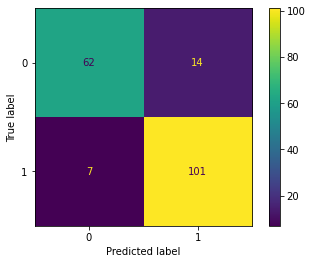

[{'Clase': 0, 'TP': 62, 'FN': 14.0, 'FP': 7.0, 'TN': 101.0}, {'Clase': 1, 'TP': 101, 'FN': 7.0, 'FP': 14.0, 'TN': 62.0}]


In [35]:
confusion_matrix = metrics.confusion_matrix(y_test, predicted)
tp, tn, fp, fn, dict_confusion = counts_from_confusion(confusion_matrix)

accuracy = metrics.accuracy_score(y_test, predicted)
recall = metrics.recall_score(y_test, predicted, average='micro')
f1 = metrics.f1_score(y_test, predicted, average='micro')
specificity = tn/(tn + fp)
sensibility = tp/(tp + fn)


print("Métricas evaluación:")
print(f"Accuracy: {accuracy:.2f}")
print(f"Recall: {recall:.2f}")
print(f"F1: {f1:.2f}")
print(f"Specificity: {specificity:.2f}")
print(f"Sensibility: {sensibility:.2f}")

# Visualizar matriz de confusión
metrics.plot_confusion_matrix(model, x_test, y_test)
plt.show()
print(dict_confusion)

## 4.6 Gradient boost

In [36]:
gbm = GradientBoostingClassifier()
model = gbm.fit(x_train, y_train)

predicted = gbm.predict(x_test)

Métricas evaluación:
Accuracy: 0.90
Recall: 0.90
F1: 0.90
Specificity: 0.90
Sensibility: 0.90


/usr/local/lib/python3.7/dist-packages/sklearn/utils/deprecation.py:87: FutureWarning: Function plot_confusion_matrix is deprecated; Function `plot_confusion_matrix` is deprecated in 1.0 and will be removed in 1.2. Use one of the class methods: ConfusionMatrixDisplay.from_predictions or ConfusionMatrixDisplay.from_estimator.
  warnings.warn(msg, category=FutureWarning)


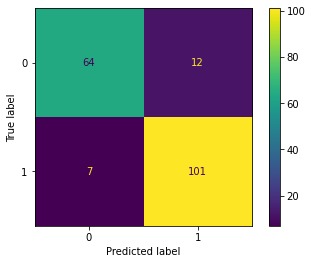

[{'Clase': 0, 'TP': 64, 'FN': 12.0, 'FP': 7.0, 'TN': 101.0}, {'Clase': 1, 'TP': 101, 'FN': 7.0, 'FP': 12.0, 'TN': 64.0}]


In [37]:
confusion_matrix = metrics.confusion_matrix(y_test, predicted)
tp, tn, fp, fn, dict_confusion = counts_from_confusion(confusion_matrix)

accuracy = metrics.accuracy_score(y_test, predicted)
recall = metrics.recall_score(y_test, predicted, average='micro')
f1 = metrics.f1_score(y_test, predicted, average='micro')
specificity = tn/(tn + fp)
sensibility = tp/(tp + fn)


print("Métricas evaluación:")
print(f"Accuracy: {accuracy:.2f}")
print(f"Recall: {recall:.2f}")
print(f"F1: {f1:.2f}")
print(f"Specificity: {specificity:.2f}")
print(f"Sensibility: {sensibility:.2f}")

# Visualizar matriz de confusión
metrics.plot_confusion_matrix(model, x_test, y_test)
plt.show()
print(dict_confusion)

In [38]:
from xgboost import XGBClassifier
from sklearn.model_selection import RepeatedStratifiedKFold
from sklearn.model_selection import cross_val_score

xgb = XGBClassifier()
mdeol = xgb.fit(x_train, y_train)

predicted = xgb.predict(x_test)

Métricas evaluación:
Accuracy: 0.90
Recall: 0.90
F1: 0.90
Specificity: 0.90
Sensibility: 0.90


/usr/local/lib/python3.7/dist-packages/sklearn/utils/deprecation.py:87: FutureWarning: Function plot_confusion_matrix is deprecated; Function `plot_confusion_matrix` is deprecated in 1.0 and will be removed in 1.2. Use one of the class methods: ConfusionMatrixDisplay.from_predictions or ConfusionMatrixDisplay.from_estimator.
  warnings.warn(msg, category=FutureWarning)


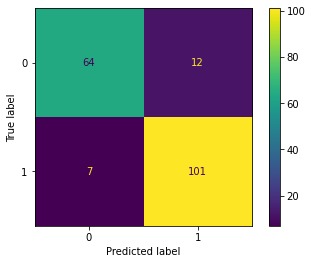

In [39]:
confusion_matrix = metrics.confusion_matrix(y_test, predicted)
tp, tn, fp, fn, dict_confusion = counts_from_confusion(confusion_matrix)

accuracy = metrics.accuracy_score(y_test, predicted)
recall = metrics.recall_score(y_test, predicted, average='micro')
f1 = metrics.f1_score(y_test, predicted, average='micro')
specificity = tn/(tn + fp)
sensibility = tp/(tp + fn)


print("Métricas evaluación:")
print(f"Accuracy: {accuracy:.2f}")
print(f"Recall: {recall:.2f}")
print(f"F1: {f1:.2f}")
print(f"Specificity: {specificity:.2f}")
print(f"Sensibility: {sensibility:.2f}")

# Visualizar matriz de confusión
metrics.plot_confusion_matrix(model, x_test, y_test)
plt.show()

Por los resultados, los modelos tipo gradient boosting esembles son los mejores. Por tanto, vamos ha apostar por ellos y profundizar en ajustar sus hyperparametros.

# 5. Ajustar modelo final

Me he basado en el siguiente articulo, para ajsutar los hyperparametros. Se trata de una revisón de diferentes papers, donde exponen como ajustar correctamente este tipo de modelos.
* **Referencia:** https://machinelearningmastery.com/configure-gradient-boosting-algorithm/

In [ ]:
params = {
    'eta': [0.01, 0.015, 0.025, 0.05, 0.1],
    'gamma': [0.05, 0.1, 0.3, 0.5, 0.7, 0.9, 1.0],
    'max_depth': [3, 5, 7, 9, 12, 15, 17, 25],
    'min_child_weight': [1, 3, 5, 7],
    'subsample': [0.6, 0.7, 0.8, 0.9, 1.0],
    'colsample_bytree': [0.6, 0.7, 0.8, 0.9, 1.0]
}

xgb = XGBClassifier()
grid_search = GridSearchCV(
    estimator=xgb,
    param_grid=params,
    scoring='roc_auc',
    n_jobs=10,
    cv=10,
    verbose=True
)

grid_search.fit(x_train, y_train)
print(grid_search.best_estimator_)